In [1]:
#libraries needed to start spark session
import pyspark
from pyspark.sql import SparkSession

#Start new spark sessioin
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("drones") \
    .getOrCreate()

#to view events/jobs in current spark session:
spark

In [2]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input

from progressbar import ProgressBar

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [3]:
path = r"/home/developer/notebooks/training"

In [4]:
# change the working directory to the path where the images are located
os.chdir(path)

In [5]:
# this list holds all the image filename
drone_images = []

In [6]:
path2 = r"/home/developer/notebooks/Images"
new_folder = r"/home/developer/notebooks/training"

In [7]:
#read in as binary
df1 = spark.read.format("binaryFile").option("pathGlobFilter", "*.png").option("recursiveFileLookup", "true").load(path2)

In [8]:
filepaths = []
for list_of_flights  in os.listdir(path2):
    filepaths.append(list_of_flights)
    print(list_of_flights)

0011f3f114a741b5b02326c9e96e597a
0001ba865c8e410e88609541b8f55ffc
DroneDownloadTest
0036dcc16c474b1abaf14d1735a7e1cf
001578c6c6b340738c9277fcb1307e34


In [70]:
# Copy first and last image of each flight into the training folder

import shutil

test_folder = "D:\Drone_project\Test_folder"

images_list = []
for flights in filepaths:
    path3 = r"/home/developer/notebooks/Images/{}".format(flights)
    for images in os.listdir(path3):
        images_list.append(images)
    first_image = images_list[0]
    temp_path = r"/home/developer/notebooks/Images/{}/{}".format(flights,first_image)
    shutil.move(str(temp_path), str(new_folder))
    length = len(images_list)
    last_image = images_list[length-2]
    temp_path = r"/home/developer/notebooks/Images/{}/{}".format(flights,last_image)
    shutil.copy(str(temp_path), str(new_folder))
    images_list.clear()

IndexError: list index out of range

In [71]:
drone_images.clear()

In [72]:
# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            drone_images.append(file.name)

In [73]:
# view the first 10 flower entries
print(drone_images[:50000])

['15549774652384706770001ba865c8e410e88609541b8f55ffc.png', '15294400118148667240022217d1ed446e9a3a5fef13d33facf.png', '15549774598149642470001ba865c8e410e88609541b8f55ffc.png', '15549773592757756650001ba865c8e410e88609541b8f55ffc.png', '15553432393330373570011f3f114a741b5b02326c9e96e597a.png', '15549774280552598100001ba865c8e410e88609541b8f55ffc.png', '15553432567166323700011f3f114a741b5b02326c9e96e597a.png', '15294400520892604650022217d1ed446e9a3a5fef13d33facf.png', '15294400049202706410022217d1ed446e9a3a5fef13d33facf.png', '15553433222057935310011f3f114a741b5b02326c9e96e597a.png', '15549774166389630360001ba865c8e410e88609541b8f55ffc.png', '15294401101527582580022217d1ed446e9a3a5fef13d33facf.png', '15294400635819053640022217d1ed446e9a3a5fef13d33facf.png', '15553432646401391020011f3f114a741b5b02326c9e96e597a.png', '15553432447237162700011f3f114a741b5b02326c9e96e597a.png', '15553432980887055330011f3f114a741b5b02326c9e96e597a.png', '15553432836988979750011f3f114a741b5b02326c9e96e597a.pn

In [74]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [75]:
pbar = ProgressBar()

In [76]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [77]:
data = {}
p = r"D:\features.pkl"

In [78]:
# lop through each image in the dataset
for drone_image in pbar(drone_images):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(drone_image,model)
        data[drone_image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

100% |########################################################################|


In [79]:
print(data)

{'15549774652384706770001ba865c8e410e88609541b8f55ffc.png': array([[0.        , 0.05287528, 1.1765428 , ..., 0.15742964, 0.        ,
        1.354462  ]], dtype=float32), '15294400118148667240022217d1ed446e9a3a5fef13d33facf.png': array([[0.730053  , 0.45315245, 1.5010012 , ..., 0.        , 1.7685864 ,
        0.        ]], dtype=float32), '15549774598149642470001ba865c8e410e88609541b8f55ffc.png': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), '15549773592757756650001ba865c8e410e88609541b8f55ffc.png': array([[0.        , 0.        , 0.        , ..., 2.3583908 , 0.        ,
        0.56139284]], dtype=float32), '15553432393330373570011f3f114a741b5b02326c9e96e597a.png': array([[0.05496085, 0.59734917, 1.4190555 , ..., 0.44367275, 0.36790827,
        0.23756641]], dtype=float32), '15549774280552598100001ba865c8e410e88609541b8f55ffc.png': array([[0.        , 0.        , 0.01273894, ..., 1.2279968 , 0.        ,
        0.        ]], dtype=float32), '15553432567166323700011f3f114a741b

In [80]:
with open('data1.pickle','wb') as file:
    pickle.dump(data,file)

In [7]:
os.path.abspath("data1.pickle")

'D:\\training\\data1.pickle'

In [8]:
with open('data1.pickle','rb') as file:
    data = pickle.load(file)

In [81]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [82]:
# get a list of just the features
feat = np.array(list(data.values()))

In [83]:
feat.shape

(25, 1, 4096)

In [84]:
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

In [14]:
# get the unique labels (from the flower_labels.csv)
df = pd.read_csv('clusters.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

In [85]:
feat.shape

(25, 4096)

In [86]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=10, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [87]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 10


In [88]:
# cluster feature vectors
kmeans = KMeans(n_clusters=3, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=3, random_state=22)

In [89]:
kmeans.labels_

array([2, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0,
       2, 1, 1], dtype=int32)

In [90]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [91]:
# Create folders for each cluster in host
for i in range(3):
    # makeadir() evaluates your condition
    out_path = 'D:\Clusters\{}'.format(i)
    if not os.path.exists(out_path):
        os.mkdir(out_path)

In [92]:
pbar2 = ProgressBar()

In [93]:
# Put all images of each cluster into thier respective folders on host for examination
source_path = r"/home/developer/notebooks/training"
# Create array from images in source path
source_list = []
for images in os.scandir(source_path):
        source_list.append(images)
# For loor copies images over into the clustered folders
for i in pbar2(range(len(kmeans.labels_))):
    folder = kmeans.labels_[i]
    out_path = r'/home/developer/notebooks/Clusters/{}'.format(folder)
    image_select = source_list[i]
    shutil.copy(image_select, out_path)

IsADirectoryError: [Errno 21] Is a directory: '/home/developer/notebooks/training/D:\\Clusters\\0'

In [94]:
pbar3 = ProgressBar()

In [61]:
# Return images back to training folder
source_path = r"D:\training"
out_path = r"D:\Clusters"
cluster_list = []
for cluster in pbar3(os.listdir(cluster_path)):
    cluster_path = r'D:\Clusters\{}'.format(cluster)
    for image_in_cluster in os.scandir(cluster_path):
        shutil.copy(image_in_cluster, source_path)

NameError: name 'cluster_path' is not defined

In [95]:
len(groups[0])

6

In [96]:
# view the filenames in cluster 0
groups[0]

['15294400118148667240022217d1ed446e9a3a5fef13d33facf.png',
 '15294400520892604650022217d1ed446e9a3a5fef13d33facf.png',
 '15294400049202706410022217d1ed446e9a3a5fef13d33facf.png',
 '15294401101527582580022217d1ed446e9a3a5fef13d33facf.png',
 '15294400135241633900022217d1ed446e9a3a5fef13d33facf.png',
 '15294401026577431840022217d1ed446e9a3a5fef13d33facf.png']

In [97]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [98]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(2, 20))

In [99]:
pbar1 = ProgressBar()

In [ ]:
for k in pbar1(list_k):
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

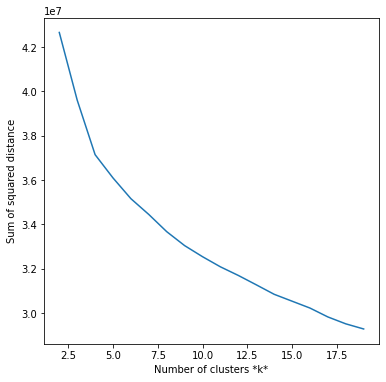

In [119]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');